# Predicting whether a person survived or not the titanic


---

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

### 1. Problem definition
Given data about each passenger , predict if they will survive or not

### 2. Data
The data set contains 10 attributes:

* survival
* pclass
* sex
* Age
* sibsp
* parch
* ticket
* fare
* cabin
* embarked

### 3. Evaluation
We need over 90 % accuracy at prediction whether a passenger survived or not

### 4. Featues
- Survival 
  * 0 = no
  * 1 = yes

- pclass: A proxy for socio-economics tatus (SES)
  * 1st = Upper
  * 2nd = Middle
  * 3rd = Lower

- Sex
 * Male
 * Female

- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp: The dataset defines family relations in this way...
  * Sibling = brother, sister, stepbrother, stepsister
  * Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
  * Parent = mother, father
  * Child = daughter, son, stepdaughter, stepson
  * Some children travelled only with a nanny, therefore parch=0 for them.

- Ticket
  * Ticket number

- Fare
 * Passenger fair

- Cabin
  * Cabin number

- Embarked
 Port of Embarkation:
 * C = Cherbourg, 
 * Q = Queenstown,
 * S = Southampton


### 5. Moddeling
Most likely to try a RandomForestRegression model and then a Deep learning tensorflow model


In [ ]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear inside the notebook
%matplotlib inline 

# Modles from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import plot_roc_curve

In [ ]:
# Set default figsize to 10 inches by 6 inches
plt.rcParams["figure.figsize"] = (10,6)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/My_machine_learning_projects/Titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_tmp = df.copy()

In [ ]:
len(df_tmp)

891

In [ ]:
df_tmp.shape

(891, 12)

In [ ]:
df_tmp.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

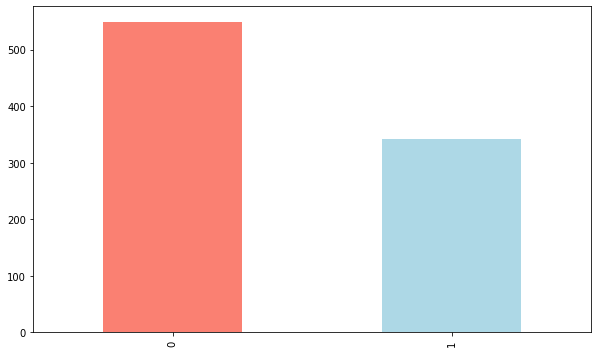

In [ ]:
df_tmp["Survived"].value_counts().plot(kind="bar",color=["salmon","lightblue"]);

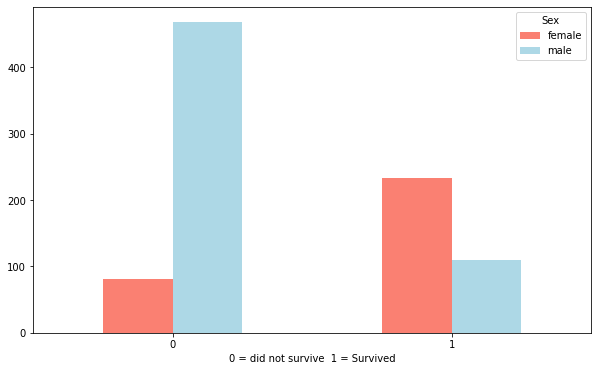

In [ ]:
pd.crosstab(df_tmp["Survived"],df_tmp.Sex).plot(kind="bar",
                                                color=["salmon","lightblue"]);
plt.rcParams.update({'font.size':10})
plt.xticks(rotation=0)
plt.xlabel("0 = did not survive  1 = Survived");

In [ ]:
print(pd.pivot_table(df_tmp,index="Survived",
               columns="Pclass",
               values="Ticket",
               aggfunc="count"))
print()
print(pd.pivot_table(df_tmp,index="Survived",
                     columns="Sex",
                     values="Ticket",
                     aggfunc="count"))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109


In [ ]:
df_tmp.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df_tmp.info

<bound method DataFrame.info of      PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0              1         0       3  ...   7.2500   NaN         S
1              2         1       1  ...  71.2833   C85         C
2              3         1       3  ...   7.9250   NaN         S
3              4         1       1  ...  53.1000  C123         S
4              5         0       3  ...   8.0500   NaN         S
..           ...       ...     ...  ...      ...   ...       ...
886          887         0       2  ...  13.0000   NaN         S
887          888         1       1  ...  30.0000   B42         S
888          889         0       3  ...  23.4500   NaN         S
889          890         1       1  ...  30.0000  C148         C
890          891         0       3  ...   7.7500   NaN         Q

[891 rows x 12 columns]>

In [ ]:
# View Numeric data
for label ,content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    print(label)

PassengerId
Survived
Pclass
Age
SibSp
Parch
Fare


In [ ]:
# View object data
for label , content in df_tmp.items():
  if pd.api.types.is_object_dtype(content):
    print(label)

Name
Sex
Ticket
Cabin
Embarked


In [ ]:
def preprocess_data(df):
  # Turn evey loccation in a 0/1 table and then drop the embarked 
  Embarked = []
  for content, label in df.items():
    if content == "Embarked":
      Embarked.append(label)

  df["Cherbourg"] = 0
  df["Queenstown"] = 0
  df["Southampton"] = 0
  df["Not specified"] = 0

  for i in range (len(Embarked)):
    if label[0][i] == "C":
      df["Cherbourg"][i] = 1
    elif label[0][i] == "S":
      df["Southampton"][i] = 1
    elif label[0][i] == "Q":
      df["Queenstown"] = 1
    else:
      df["Not specified"] = 1 

  df.drop("Embarked",axis = 1, inplace=True)

  # Fill Cabin missing data with No cabin parameter
  df["Cabin"] = df["Cabin"].fillna("No Cabin")

  # Fill numeric rows with the median
  for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
      if pd.isnull(content).sum():
        # Add a binary column which tells us if the data was missing
        df[label+"_is_missing"] = pd.isnull(content)
        # Fill missing values with the median
        df[label] = content.fillna(content.mean())

  # Turn categorical variables into numbers and fill missing 
  for label ,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
      # Add a binary column to indicate whether sample had missing values
      df[label+"_is_missing"] = pd.isnull(content)
      # Turn categories into numbers and add +1
      df[label] = df[label].str.replace(',','','.')
      df[label] = pd.Categorical(content).codes + 1

  # Turn categorical variables into numbers


  return df

In [ ]:
df_tmp = preprocess_data(df_tmp)
df_tmp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Cherbourg,Queenstown,Southampton,Not specified,Age_is_missing,Name_is_missing,Sex_is_missing,Ticket_is_missing,Cabin_is_missing
0,1,0,3,109,2,22.000000,1,0,524,7.2500,147,0,0,1,0,False,False,False,False,False
1,2,1,1,191,1,38.000000,1,0,597,71.2833,82,0,0,0,0,False,False,False,False,False
2,3,1,3,354,1,26.000000,0,0,670,7.9250,147,0,0,0,0,False,False,False,False,False
3,4,1,1,273,1,35.000000,1,0,50,53.1000,56,0,0,0,0,False,False,False,False,False
4,5,0,3,16,2,35.000000,0,0,473,8.0500,147,0,0,0,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,549,2,27.000000,0,0,102,13.0000,147,0,0,0,0,False,False,False,False,False
887,888,1,1,304,1,19.000000,0,0,15,30.0000,31,0,0,0,0,False,False,False,False,False
888,889,0,3,414,1,29.699118,1,2,676,23.4500,147,0,0,0,0,True,False,False,False,False
889,890,1,1,82,2,26.000000,0,0,9,30.0000,61,0,0,0,0,False,False,False,False,False


In [ ]:
# Check if there are any null object values
for label , content in df_tmp.items():
  if pd.api.types.is_object_dtype(content):
    if pd.isnull(content).sum():
      print(label)

In [ ]:
# Check if there are any null numeric values
for label , content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

In [ ]:
df_tmp.dtypes

PassengerId            int64
Survived               int64
Pclass                 int64
Name                   int16
Sex                     int8
Age                  float64
SibSp                  int64
Parch                  int64
Ticket                 int16
Fare                 float64
Cabin                  int16
Cherbourg              int64
Queenstown             int64
Southampton            int64
Not specified          int64
Age_is_missing          bool
Name_is_missing         bool
Sex_is_missing          bool
Ticket_is_missing       bool
Cabin_is_missing        bool
dtype: object

In [ ]:
# Make training sets
X_train = df_tmp.drop("Survived",axis=1)
y_train = df_tmp["Survived"]

In [ ]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth":[None,3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "min_samples_leaf":np.arange(1,20,2)}

In [ ]:
# %%time

# # Set up random hyperparameter search for RandomForestClassifier
# gs_log_reg = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
#                           param_distributions=rf_grid,
#                           cv=5,
#                           n_iter=800,
#                           verbose=True)

# gs_log_reg.fit(X_train,y_train)

In [ ]:
pip install catboost

     |████████████████████████████████| 65.8MB 46kB/s 


In [ ]:
from catboost import CatBoostClassifier,Pool,cv
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [ ]:
# Cat boost train pool
train_pool = Pool(X_train,y_train,cat_features)

In [ ]:

cat_model = CatBoostClassifier(iterations=1000,
                               task_type="GPU",
                               loss_function='Logloss',
                               custom_loss=['Accuracy'])

cat_model.fit(train_pool,plot=True)
acc_catboost = round(cat_model.score(X_train, y_train) * 100, 2)

In [ ]:
acc_catboost

94.16

In [ ]:
cv_params = cat_model.get_params()

cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6816175	test: 0.6813993	best: 0.6813993 (0)
1:	learn: 0.6707338	test: 0.6707138	best: 0.6707138 (1)
2:	learn: 0.6601537	test: 0.6598655	best: 0.6598655 (2)
3:	learn: 0.6488304	test: 0.6476621	best: 0.6476621 (3)
4:	learn: 0.6401324	test: 0.6389850	best: 0.6389850 (4)
5:	learn: 0.6311641	test: 0.6297523	best: 0.6297523 (5)
6:	learn: 0.6221104	test: 0.6207013	best: 0.6207013 (6)
7:	learn: 0.6134407	test: 0.6120911	best: 0.6120911 (7)
8:	learn: 0.6056243	test: 0.6042021	best: 0.6042021 (8)
9:	learn: 0.5983794	test: 0.5963840	best: 0.5963840 (9)
10:	learn: 0.5931077	test: 0.5911044	best: 0.5911044 (10)
11:	learn: 0.5868480	test: 0.5840411	best: 0.5840411 (11)
12:	learn: 0.5809739	test: 0.5779188	best: 0.5779188 (12)
13:	learn: 0.5757528	test: 0.5725655	best: 0.5725655 (13)
14:	learn: 0.5702716	test: 0.5666568	best: 0.5666568 (14)
15:	learn: 0.5650755	test: 0.5614362	best: 0.5614362 (15)
16:	learn: 0.5593428	test: 0.5553851	best: 0.5553851 (16)
17:	learn: 0.5540605	test: 0.54959

In [ ]:
acc_cv_catboost

83.96

In [ ]:
# Import test data
df_test = pd.read_csv("/content/drive/MyDrive/My_machine_learning_projects/Titanic/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
df_test = preprocess_data(df_test)

In [ ]:
set(X_train.columns) - set(df_test.columns)

{'Age_is_missing'}

In [ ]:
df_test["Age_is_missing"] = False

In [ ]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Cherbourg,Queenstown,Southampton,Not specified,Age_is_missing,Name_is_missing,Sex_is_missing,Ticket_is_missing,Cabin_is_missing
0,1,3,109,2,22.000000,1,0,524,7.2500,147,0,0,1,0,False,False,False,False,False
1,2,1,191,1,38.000000,1,0,597,71.2833,82,0,0,0,0,False,False,False,False,False
2,3,3,354,1,26.000000,0,0,670,7.9250,147,0,0,0,0,False,False,False,False,False
3,4,1,273,1,35.000000,1,0,50,53.1000,56,0,0,0,0,False,False,False,False,False
4,5,3,16,2,35.000000,0,0,473,8.0500,147,0,0,0,0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,549,2,27.000000,0,0,102,13.0000,147,0,0,0,0,False,False,False,False,False
887,888,1,304,1,19.000000,0,0,15,30.0000,31,0,0,0,0,False,False,False,False,False
888,889,3,414,1,29.699118,1,2,676,23.4500,147,0,0,0,0,True,False,False,False,False
889,890,1,82,2,26.000000,0,0,9,30.0000,61,0,0,0,0,False,False,False,False,False


In [ ]:

df_test["Age"] = df_test["Age"].fillna(df_test.Age.mean())
df_test["Fare"] = df_test["Fare"].fillna(df_test.Fare.median())

In [ ]:
df_test.isna().sum()

PassengerId          0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin                0
Cherbourg            0
Queenstown           0
Southampton          0
Not specified        0
Name_is_missing      0
Sex_is_missing       0
Ticket_is_missing    0
Cabin_is_missing     0
Age_is_missing       0
dtype: int64

In [ ]:
test_preds = cat_model.predict(df_test)

In [ ]:
df_preds = pd.DataFrame()

df_preds["PassengerId"] = df_test["PassengerId"]
df_preds["Survived"] = test_preds
df_preds

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
# Export prediction data

df_preds.to_csv("/content/drive/MyDrive/My_machine_learning_projects/Titanic/cat_boost_model_v3.csv",index=False)
